In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xarray as xr
import math

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

D:\Conda\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Running Model with RCIMP

In [2]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)  # start, end, step

"""
scenarios = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
"""

scenarios_Rcimp = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios_Rcimp)
fair_params_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)
fair_species_configs_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species_Rcimp, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species_Rcimp, properties)
f.allocate()
"""
f.fill_from_csv(
    emissions_file='examples/data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='examples/data/calibrated_constrained_ensemble/volcanic_solar.csv',
)
"""
f.fill_from_rcmip()


f.forcing.sel(specie="Volcanic")
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()



Running 6728 projections in parallel: 100%|██████████| 550/550 [00:48<00:00, 11.42timesteps/s]


Running model with data from calibrated ensenbles

In [3]:
f2 = FAIR(ch4_method="Thornhill2021")
f2.define_time(1750, 2300, 1)  # start, end, step
scenarios_data = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
f2.define_scenarios(scenarios_data)
fair_params_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f2.define_configs(configs)
fair_species_configs_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species_data, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f2.define_species(species_data, properties)
f2.allocate()
f2.fill_from_csv(
    emissions_file='examples/data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='examples/data/calibrated_constrained_ensemble/volcanic_solar.csv',
)


f2.forcing.sel(specie="Volcanic")
fill(
    f2.forcing,
    f2.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f2.forcing,
    f2.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f2.fill_species_configs(fair_species_configs_1_4_1_file)
f2.override_defaults(fair_params_1_4_1_file)
initialise(f2.concentration, f2.species_configs["baseline_concentration"])
initialise(f2.forcing, 0)
initialise(f2.temperature, 0)
initialise(f2.cumulative_emissions, 0)
initialise(f2.airborne_emissions, 0)
initialise(f2.ocean_heat_content_change, 0)
f2.run()



Running 5887 projections in parallel: 100%|██████████| 550/550 [00:44<00:00, 12.24timesteps/s]


# Adding 6 new species for forcing calculation

- Finding max forcing, average each config, report STDV as error
- Writing into the Rcimp max forcing df
- ariNH3  shape=(550, 8, 841) (years, scenarios, configs)

## For RCIMP data

### Creating 3d arrays for new species from model's emissions and concentration

In [4]:
ariNH3 = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    ariNH3[:,:,i] = df_configs["erfari_radiative_efficiency[NH3]"].iloc[i]*(f.emissions.loc[dict(specie='NH3')][:,:,i]-f.emissions.loc[dict(specie='NH3')][0,:,i])

o3CO = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3CO[:,:,i] = df_configs["ozone_radiative_efficiency[CO]"].iloc[i]*(f.emissions.loc[dict(specie='CO')][:,:,i]-f.emissions.loc[dict(specie='CO')][0,:,i])

o3VOC = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3VOC[:,:,i] = (df_configs["ozone_radiative_efficiency[VOC]"].iloc[i] + df_configs["erfari_radiative_efficiency[VOC]"].iloc[i])*(f.emissions.loc[dict(specie='VOC')][:,:,i]-f.emissions.loc[dict(specie='VOC')][0,:,i])

o3ariNOx = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3ariNOx[:,:,i] = (df_configs["ozone_radiative_efficiency[NOx]"].iloc[i]+df_configs["erfari_radiative_efficiency[NOx]"].iloc[i])*(f.emissions.loc[dict(specie='NOx')][:,:,i]-f.emissions.loc[dict(specie='NOx')][0,:,i])

In [20]:
species_df = pd.read_csv("examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv")

allCH4 = np.zeros((np.size(f.timebounds),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    allCH4[:,:,i] = (df_configs["ozone_radiative_efficiency[CH4]"].iloc[i] + df_configs["erfari_radiative_efficiency[CH4]"].iloc[i] + species_df['h2o_stratospheric_factor'][3] * df_configs['forcing_scale[Stratospheric water vapour]'].iloc[i] )*(f.concentration.loc[dict(specie='CH4')][:,:,i]-f.concentration.loc[dict(specie='CH4')][0,:,i]) + f.forcing.loc[dict(specie='CH4')][:,:,i]

o3N2O = np.zeros((np.size(f.timebounds),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3N2O[:,:,i] = (df_configs["ozone_radiative_efficiency[N2O]"].iloc[i] + df_configs["erfari_radiative_efficiency[N2O]"].iloc[i])*(f.concentration.loc[dict(specie='N2O')][:,:,i]-f.concentration.loc[dict(specie='N2O')][0,:,i]) + f.forcing.loc[dict(specie='N2O')][:,:,i]

### Transfering 3d array to darray object

In [22]:
def to_darray(specie_array, specie_name, model):
    # trim the shape, add 0
    specie_array_resized = np.zeros((551, len(model.forcing['scenario']), 841))
    original_shape = specie_array.shape
    specie_array_resized[:original_shape[0], :original_shape[1], :original_shape[2]] = specie_array

    specie_darray = xr.DataArray(
    specie_array_resized,
    dims=['timebounds', 'scenario', 'config'],
    coords={
        'timebounds': model.forcing.coords['timebounds'].values,
        'scenario': model.forcing.coords['scenario'].values,
        'config': model.forcing.coords['config'].values
    },
    name=specie_name)

    specie_darray = specie_darray.expand_dims({"specie": [specie_name]})
    return specie_darray

ariNH3_da = to_darray(ariNH3, 'ariNH3', f)
o3VOC_da = to_darray(o3VOC, 'o3VOC', f)
o3CO_da = to_darray(o3CO, 'o3CO', f)
o3ariNOx_da = to_darray(o3ariNOx, 'o3ariNOx', f)
allCH4_da = to_darray(allCH4, 'allCH4', f)
o3N2O_da = to_darray(o3N2O, 'o3N2O', f)

Neg_ariNH3_da = to_darray(-ariNH3, 'Neg_ariNH3', f)
Neg_o3VOC_da = to_darray(-o3VOC, 'Neg_o3VOC', f)
Neg_o3CO_da = to_darray(-o3CO, 'Neg_o3CO', f)
Neg_o3ariNOx_da = to_darray(-o3ariNOx, 'Neg_o3ariNOx', f)
Neg_allCH4_da = to_darray(-allCH4, 'Neg_allCH4', f)
Neg_o3N2O_da = to_darray(-o3N2O, 'Neg_o3N2O', f)

forcing_clone = f.forcing.copy()
forcing_clone = xr.concat([forcing_clone, ariNH3_da, o3CO_da, o3VOC_da, o3ariNOx_da, Neg_ariNH3_da, Neg_o3CO_da, Neg_o3VOC_da, Neg_o3ariNOx_da, allCH4_da, o3N2O_da, Neg_allCH4_da, Neg_o3N2O_da], dim="specie")
forcing_clone.specie

<xarray.DataArray 'specie' (specie: 73)> Size: 584B
array(['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC',
       'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114',
       'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3',
       'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12',
       'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125', 'HFC-134a',
       'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'Solar', 'Volcanic',
       'Aerosol-radiation interactions', 'Aerosol-cloud interactions', 'Ozone',
       'Light absorbing particles on snow and ice',
       'Stratospheric water vapour', 'Land use',
       'Equivalent effective stratospheric chlorine', 'ariNH3', 'o3CO',
       'o3VOC', 'o3ariNOx', 'Neg_ariNH3', 'Neg_o3CO', 'Neg_o3VOC',
       'Neg_o3ariNOx', 'allCH4', 'o3N2O', 'Neg_allCH4', 'Neg_o3N2O'],
      dtype=object)
Coordinates:
  * specie   (specie) object 584B 'CO2 FFI' 'CO2 AFOLU' ... 'Neg_o3N2O'

### Removed: Ozone; CH4; N2O; Stratosphere water vapor

In [34]:
to_remove = ['Ozone', 'CH4', 'N2O', 'Stratospheric water vapour']
forcing_clone = forcing_clone.drop_sel(specie=to_remove)

### Writing darray objects into one dataframe (df1 for RCIMP model)

In [35]:
max_forcing = forcing_clone.max(dim='timebounds')
idx = forcing_clone.argmax(dim='timebounds')
max_forcing_year = forcing_clone['timebounds'].isel(timebounds=idx)

ds1 = xr.Dataset({
    'max_forcing':       max_forcing,
    'max_forcing_year':  max_forcing_year
})
df1 = ds1.to_dataframe().reset_index()

df1['config']            = df1['config'].astype(int)
df1['max_forcing_year']  = df1['max_forcing_year'].astype(int)
df1.drop(columns=['timebounds'], inplace=True)
df1.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv',
          index=False)

In [38]:
df1[df1['specie'] == 'Stratospheric water vapour']

,scenario,config,specie,max_forcing,max_forcing_year


## for 7 scenario in extension 1750-2500

### Creating 3d arrays for new species from model's emissions and concentration

In [9]:
ariNH3_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    ariNH3_f2[:,:,i] = df_configs["erfari_radiative_efficiency[NH3]"].iloc[i]*(f2.emissions.loc[dict(specie='NH3')][:,:,i]-f2.emissions.loc[dict(specie='NH3')][0,:,i])

o3CO_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    o3CO_f2[:,:,i] = df_configs["ozone_radiative_efficiency[CO]"].iloc[i]*(f2.emissions.loc[dict(specie='CO')][:,:,i]-f2.emissions.loc[dict(specie='CO')][0,:,i])

o3VOC_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    o3VOC_f2[:,:,i] = (df_configs["ozone_radiative_efficiency[VOC]"].iloc[i] + df_configs["erfari_radiative_efficiency[VOC]"].iloc[i])*(f2.emissions.loc[dict(specie='VOC')][:,:,i]-f2.emissions.loc[dict(specie='VOC')][0,:,i])

o3ariNOx_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    o3ariNOx_f2[:,:,i] = (df_configs["ozone_radiative_efficiency[NOx]"].iloc[i]+df_configs["erfari_radiative_efficiency[NOx]"].iloc[i])*(f2.emissions.loc[dict(specie='NOx')][:,:,i]-f2.emissions.loc[dict(specie='NOx')][0,:,i])

TODO:
- Add Below Two
- Remove: Ozone CH4 N2O Stra.watervapor
- Check out diff between RCMIP and extention  (Plotting, both ranking and forcing)

In [10]:
species_df = pd.read_csv("examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv")

allCH4_f2 = np.zeros((np.size(f2.timebounds),7,np.size(configs)))
for i in range(np.size(configs)):
    allCH4_f2[:,:,i] = (df_configs["ozone_radiative_efficiency[CH4]"].iloc[i] + df_configs["erfari_radiative_efficiency[CH4]"].iloc[i] + species_df['h2o_stratospheric_factor'][3] * df_configs['forcing_scale[Stratospheric water vapour]'].iloc[i] )*(f2.concentration.loc[dict(specie='CH4')][:,:,i]-f2.concentration.loc[dict(specie='CH4')][0,:,i]) + f2.forcing.loc[dict(specie='CH4')][:,:,i]

o3N2O_f2 = np.zeros((np.size(f2.timebounds),7,np.size(configs)))
for i in range(np.size(configs)):
    o3N2O_f2[:,:,i] = (df_configs["ozone_radiative_efficiency[N2O]"].iloc[i] + df_configs["erfari_radiative_efficiency[N2O]"].iloc[i])*(f2.concentration.loc[dict(specie='N2O')][:,:,i]-f2.concentration.loc[dict(specie='N2O')][0,:,i]) + f2.forcing.loc[dict(specie='N2O')][:,:,i]

### Transfering 3d array to darray object

In [13]:
ariNH3_da_f2 = to_darray(ariNH3_f2, 'ariNH3', f2)
o3VOC_da_f2 = to_darray(o3VOC_f2, 'o3VOC', f2)
o3CO_da_f2 = to_darray(o3CO_f2, 'o3CO', f2)
o3ariNOx_da_f2 = to_darray(o3ariNOx_f2, 'o3ariNOx', f2)
allCH4_da_f2 = to_darray(allCH4_f2, 'allCH4', f2)
o3N2O_da_f2 = to_darray(o3N2O_f2, 'o3N2O', f2)

Neg_ariNH3_da_f2 = to_darray(-ariNH3_f2, 'Neg_ariNH3', f2)
Neg_o3VOC_da_f2 = to_darray(-o3VOC_f2, 'Neg_o3VOC', f2)
Neg_o3CO_da_f2 = to_darray(-o3CO_f2, 'Neg_o3CO', f2)
Neg_o3ariNOx_da_f2 = to_darray(-o3ariNOx_f2, 'Neg_o3ariNOx', f2)
Neg_allCH4_da_f2 = to_darray(-allCH4_f2, 'Neg_allCH4', f2)
Neg_o3N2O_da_f2 = to_darray(-o3N2O_f2, 'Neg_o3N2O', f2)

forcing_clone_f2 = f2.forcing.copy()
forcing_clone_f2 = xr.concat([forcing_clone_f2, ariNH3_da_f2, o3CO_da_f2, o3VOC_da_f2, o3ariNOx_da_f2, Neg_ariNH3_da_f2, Neg_o3CO_da_f2, Neg_o3VOC_da_f2, Neg_o3ariNOx_da_f2, allCH4_da_f2, o3N2O_da_f2, Neg_allCH4_da_f2, Neg_o3N2O_da_f2], dim="specie")
forcing_clone_f2.specie

<xarray.DataArray 'specie' (specie: 73)> Size: 584B
array(['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC',
       'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114',
       'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3',
       'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12',
       'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125', 'HFC-134a',
       'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'Solar', 'Volcanic',
       'Aerosol-radiation interactions', 'Aerosol-cloud interactions', 'Ozone',
       'Light absorbing particles on snow and ice',
       'Stratospheric water vapour', 'Land use',
       'Equivalent effective stratospheric chlorine', 'ariNH3', 'o3CO',
       'o3VOC', 'o3ariNOx', 'Neg_ariNH3', 'Neg_o3CO', 'Neg_o3VOC',
       'Neg_o3ariNOx', 'allCH4', 'o3N2O', 'Neg_allCH4', 'Neg_o3N2O'],
      dtype=object)
Coordinates:
  * specie   (specie) object 584B 'CO2 FFI' 'CO2 AFOLU' ... 'Neg_o3N2O'

### Removed: Ozone; CH4; N2O; Stratosphere water vapor

In [30]:
to_remove = ['Ozone', 'CH4', 'N2O', 'Stratospheric water vapour']
forcing_clone_f2 = forcing_clone_f2.drop_sel(specie=to_remove)

### Writing darray objects into one dataframe (df2 for model from extension_1750-2500)

In [32]:
max_forcing = forcing_clone_f2.max(dim='timebounds')
idx = forcing_clone_f2.argmax(dim='timebounds')
max_forcing_year = forcing_clone_f2['timebounds'].isel(timebounds=idx)

ds2 = xr.Dataset({
    'max_forcing':       max_forcing,
    'max_forcing_year':  max_forcing_year
})
df2 = ds2.to_dataframe().reset_index()

df2['config']            = df2['config'].astype(int)
df2['max_forcing_year']  = df2['max_forcing_year'].astype(int)
df2.drop(columns=['timebounds'], inplace=True)
df2.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_cali.csv',
          index=False)

In [39]:
df2[df2['specie'] == 'Neg_o3N2O']

,scenario,config,specie,max_forcing,max_forcing_year
68,high-extension,1234,Neg_o3N2O,0.000017,1754
137,high-extension,2451,Neg_o3N2O,0.000023,1754
206,high-extension,5859,Neg_o3N2O,0.000024,1754
275,high-extension,5883,Neg_o3N2O,0.000020,1754
344,high-extension,14573,Neg_o3N2O,0.000023,1754
...,...,...,...,...,...
405926,verylow-overshoot,1590667,Neg_o3N2O,0.000017,1754
405995,verylow-overshoot,1590821,Neg_o3N2O,0.000022,1754
406064,verylow-overshoot,1592589,Neg_o3N2O,0.000019,1754
406133,verylow-overshoot,1594247,Neg_o3N2O,0.000020,1754


# Find out average max forcing a range of year

In [40]:
def summarize_forcing(forcing_df):
    summary_df = (forcing_df.groupby(['scenario', 'specie'])
                  .agg({'max_forcing': ['mean', 'std'],
                        'max_forcing_year': lambda x: (min(x), max(x))})
                  .reset_index())
    summary_df.columns = ['scenario', 'specie', 'mean_max_forcing', 'max_forcing_std', 'max_forcing_year']
    summary_df[['min_year', 'max_year']] = pd.DataFrame(summary_df['max_forcing_year'].tolist(), index=summary_df.index)
    summary_df['year_range'] = summary_df['max_year'] - summary_df['min_year']
    summary_df["std_by_scenario"] = summary_df.groupby('specie')['mean_max_forcing'].transform('std')
    summary_df["mean_by_scenario"] = summary_df.groupby('specie')['mean_max_forcing'].transform('mean')
    summary_df["cv_by_scenario"] = (summary_df["std_by_scenario"]/summary_df["mean_by_scenario"]).fillna(0)
    summary_df.drop(columns=["std_by_scenario", "mean_by_scenario", 'max_forcing_year'], inplace=True)

    return summary_df

summary_rcimp = summarize_forcing(df1)
summary_cali = summarize_forcing(df2)

In [41]:
summary_cali[summary_cali['specie'] == 'Neg_allCH4']

,scenario,specie,mean_max_forcing,max_forcing_std,min_year,max_year,year_range,cv_by_scenario
49,high-extension,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0
118,high-overshoot,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0
187,low,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0
256,medium-extension,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0
325,medium-overshoot,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0
394,verylow,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0
463,verylow-overshoot,Neg_allCH4,0.000098,0.000009,1753,1753,0,0.0


In [42]:
summary_rcimp[summary_rcimp['specie'] == 'Neg_allCH4']

,scenario,specie,mean_max_forcing,max_forcing_std,min_year,max_year,year_range,cv_by_scenario
49,ssp119,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
118,ssp126,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
187,ssp245,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
256,ssp370,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
325,ssp434,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
394,ssp460,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
463,ssp534-over,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0
532,ssp585,Neg_allCH4,0.081915,0.007897,1787,1788,1,0.0


In [43]:
summary_rcimp.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_summary_Rcimp.csv')
summary_cali.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_summary_Cali.csv')

method for plotting

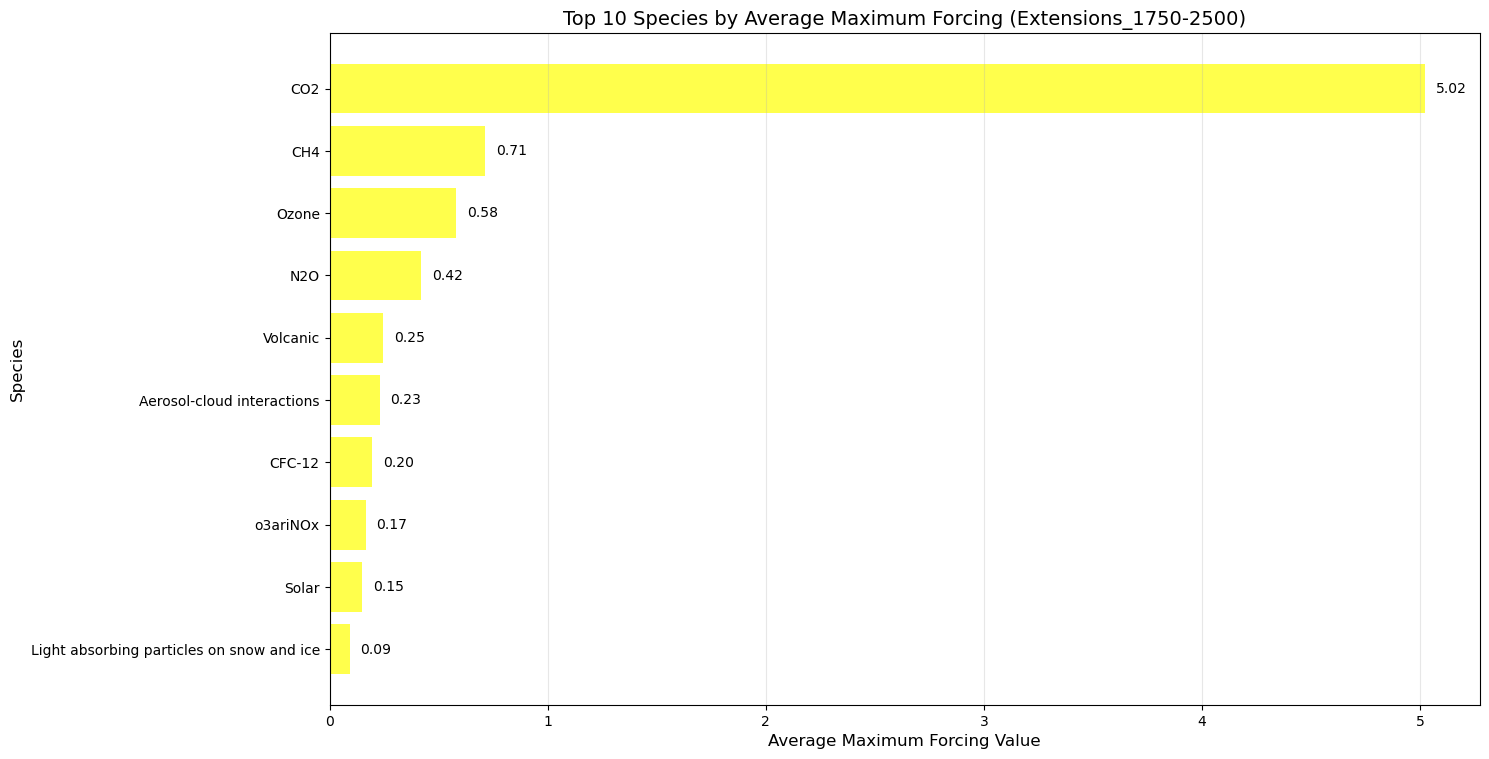

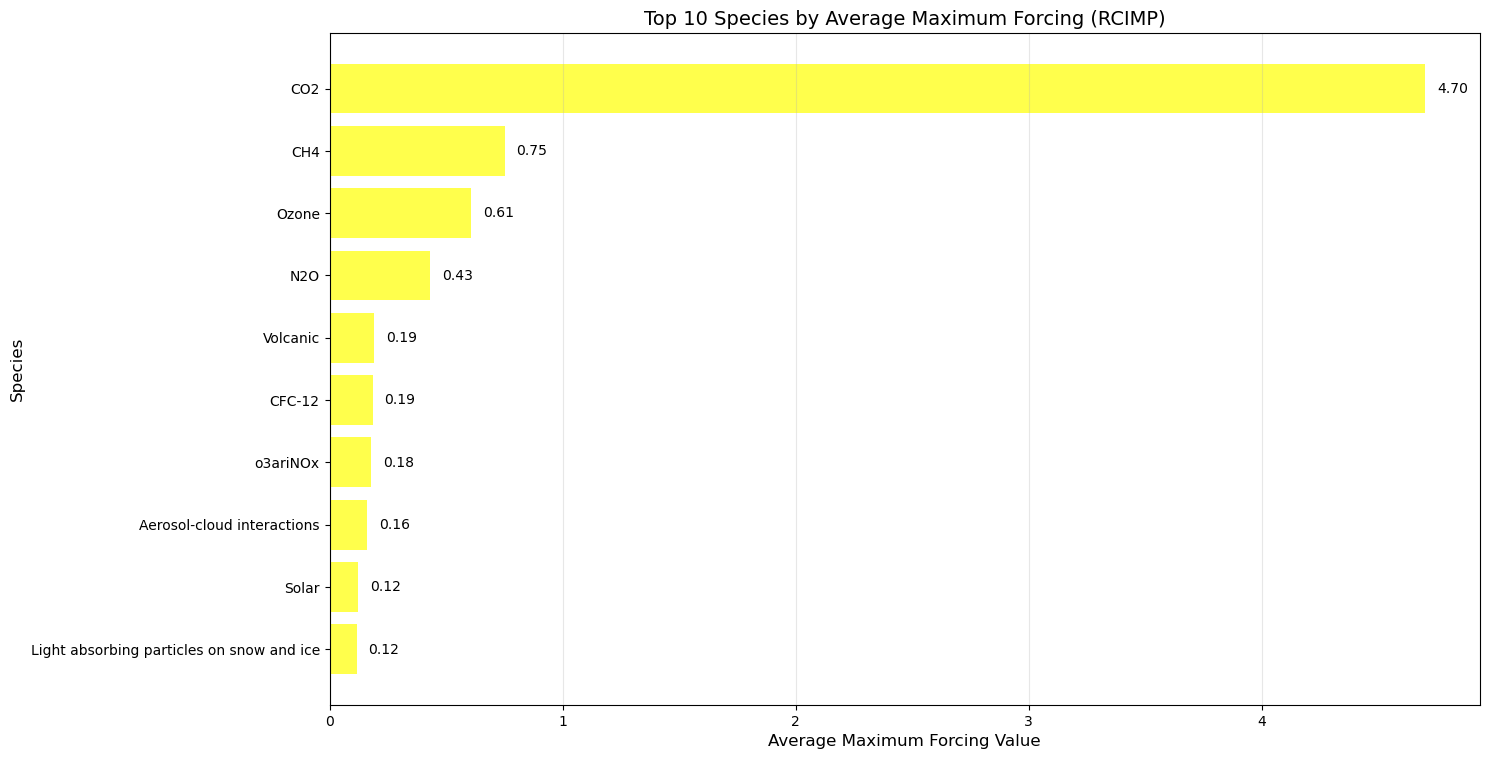

In [18]:
def plot_top(ploting_df, top_number, title_suffix):
    if top_number > ploting_df.nunique()['specie']:
        top_number = ploting_df.nunique()['specie']

    top_species = ploting_df.groupby('specie')['mean_max_forcing'].mean().nlargest(top_number).sort_values(ascending=True)

    pl.figure(figsize=(15, top_number/1.3))
    bars = pl.barh(top_species.index, top_species.values, color='yellow', alpha=0.7)
    pl.xlabel('Average Maximum Forcing Value', fontsize=12)
    pl.ylabel('Species', fontsize=12)
    title = 'Top {} Species by Average Maximum Forcing '.format(top_number) + title_suffix
    pl.title(title, fontsize=14)
    pl.grid(axis='x', alpha=0.3)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        pl.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                 ha='left', va='center', fontsize=10)

    pl.tight_layout()
    pl.show()

plot_top(summary_cali, 10, '(Extensions_1750-2500)')
plot_top(summary_rcimp, 10, '(RCIMP)')

# Ranking

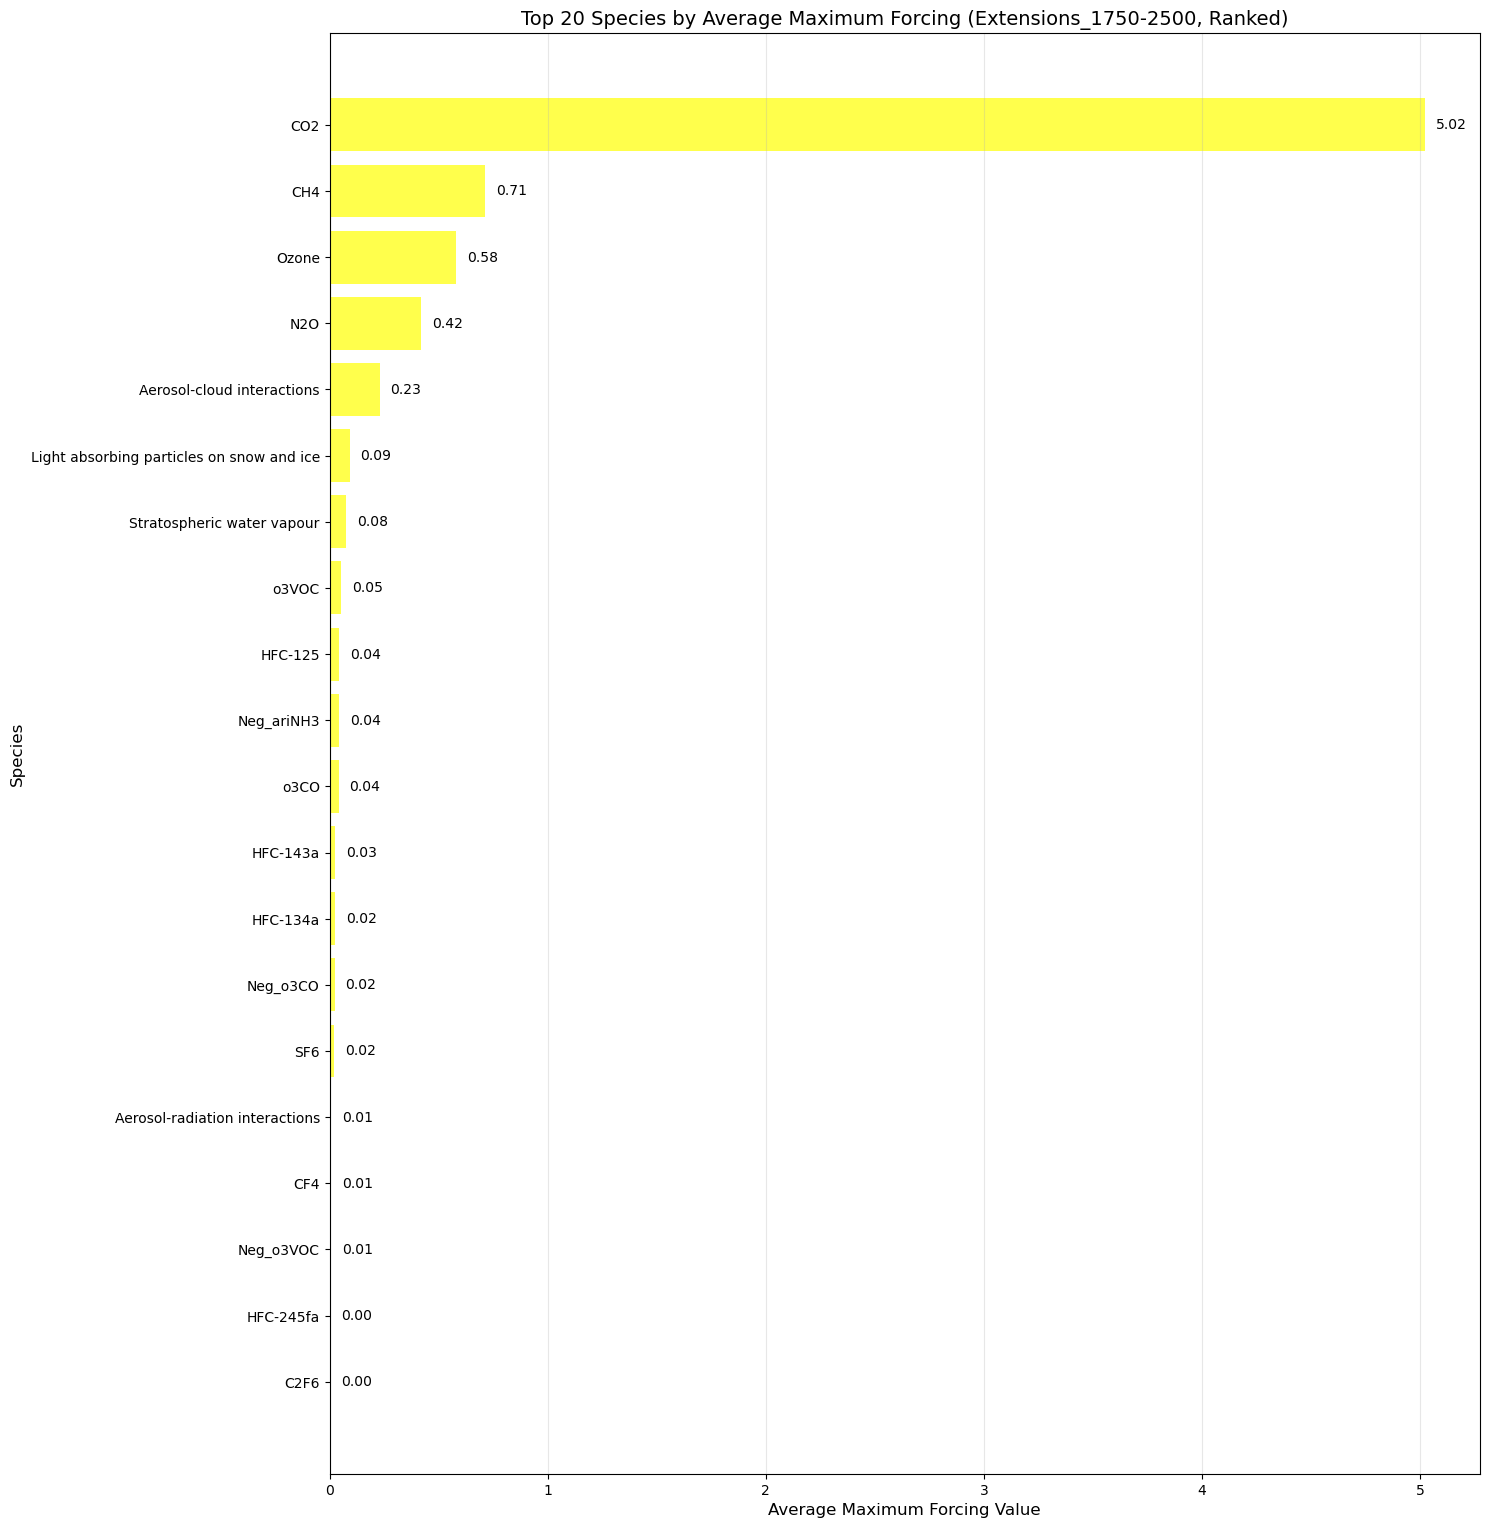

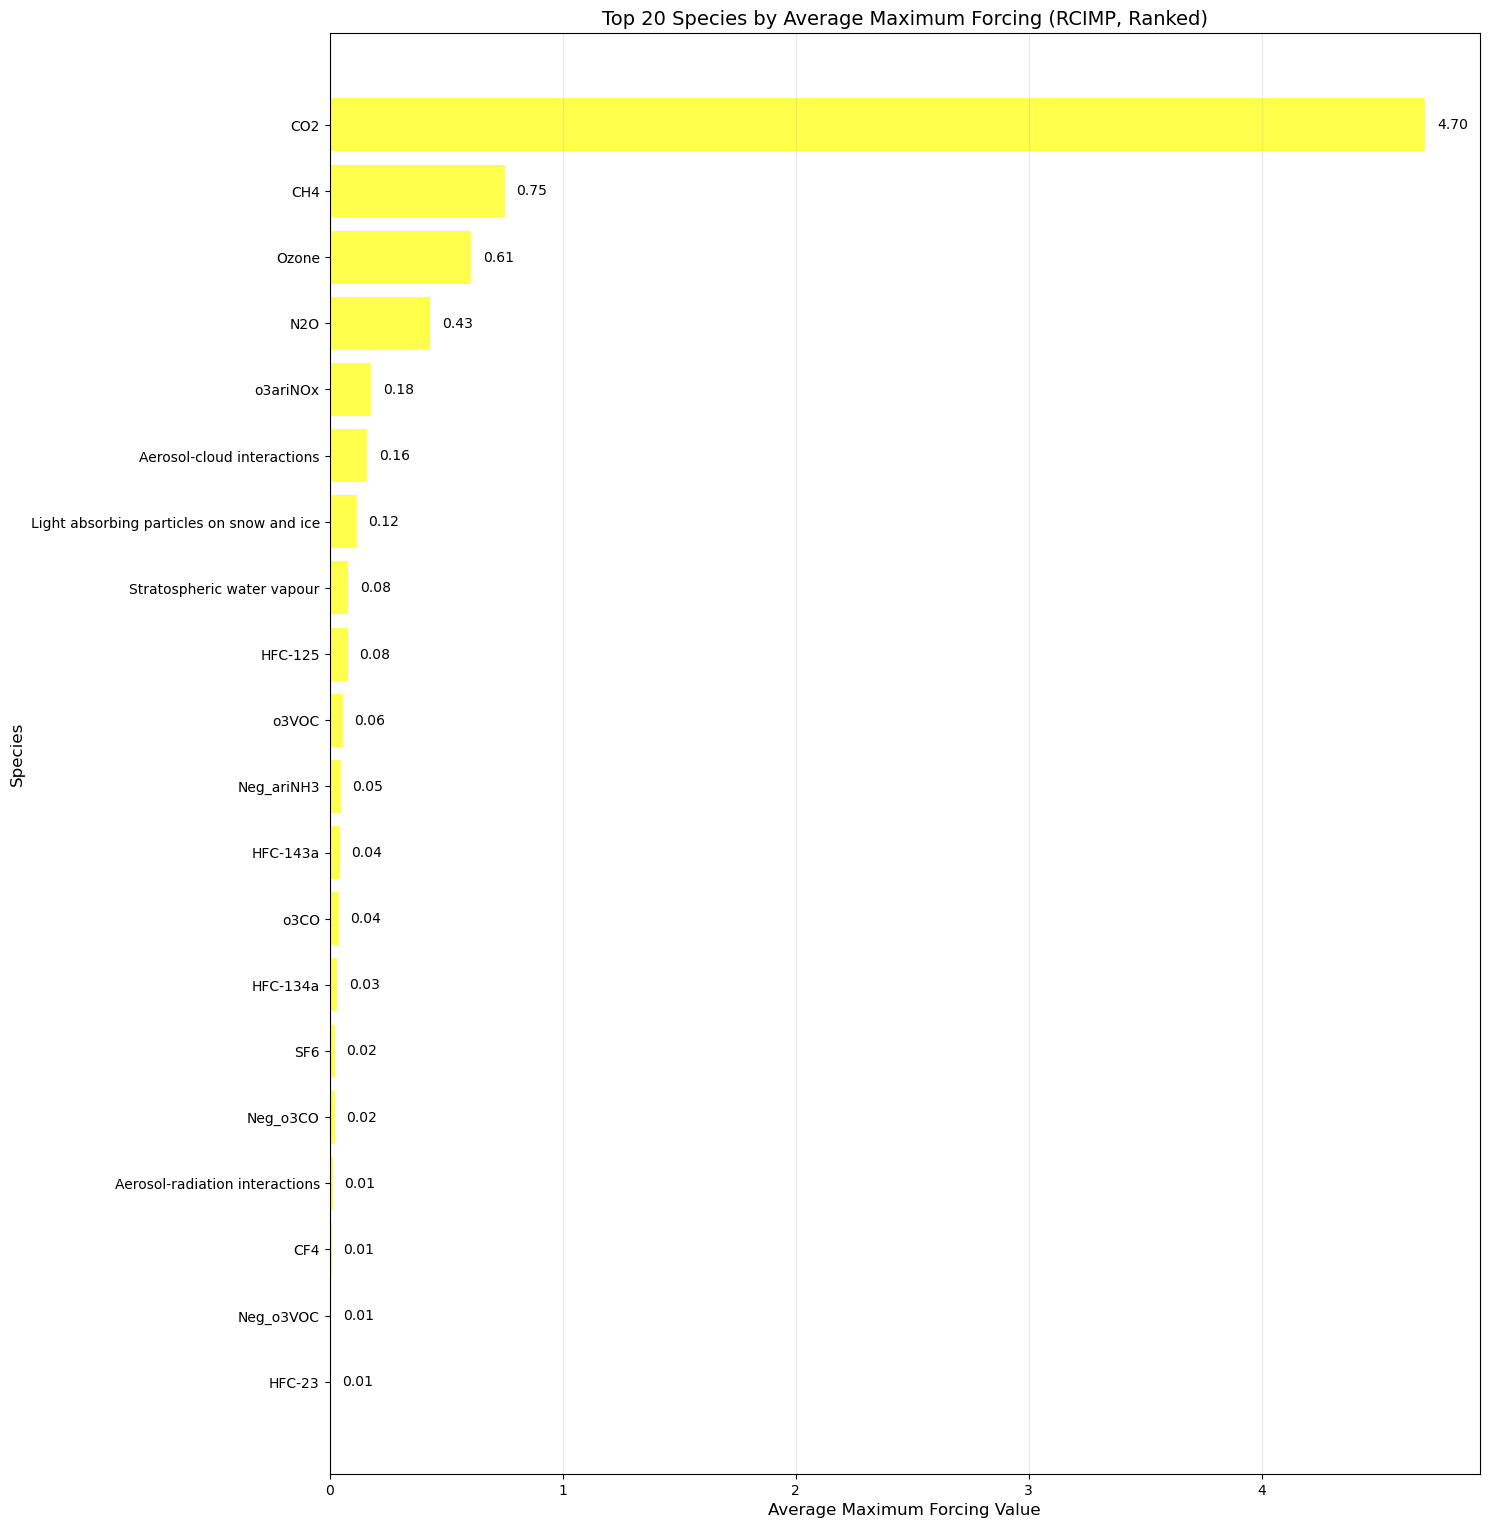

In [19]:
def ranking(forcing_df, max_threshold, cv_threshold, output_number = 100000000):

    forcing_df = forcing_df[forcing_df['mean_max_forcing'] > max_threshold]
    forcing_df = forcing_df[forcing_df['cv_by_scenario'] > cv_threshold]

    return forcing_df.sort_values("mean_max_forcing", ascending = False).head(output_number)

ranked_df_cali = ranking(summary_cali.copy(), 0.000000001, 0.00000000001)
ranked_df_rcimp = ranking(summary_rcimp.copy(), 0.000000001, 0.00000000001)
plot_top(ranked_df_cali, 20, '(Extensions_1750-2500, Ranked)')
plot_top(ranked_df_rcimp, 20, '(RCIMP, Ranked)')

# (unused)Max Forcing Calculation

In [20]:
def array_to_dict(specie_array, scenario_array):
    output = {}
    index = 0
    for scenario in scenario_array:
        output[scenario] = specie_array[:, index, :]
        index += 1
    return output

ariNH3_dict = array_to_dict(ariNH3, scenarios_Rcimp)
o3CO_dict = array_to_dict(o3CO, scenarios_Rcimp)
o3VOC_dict = array_to_dict(o3VOC, scenarios_Rcimp)
o3ariNOx_dict = array_to_dict(o3ariNOx, scenarios_Rcimp)

In [21]:
def array_forcing(specie_array, scenario_array, model):
    # returns tuple of max_forcing dict, and standard deviation for each scenario
    output = {}
    std_scenario = {}
    scenario_index = 0
    for scenario in scenario_array:
        max_forcing_array = []
        max_year_array = []
        for config in range(np.shape(specie_array)[2]):
            
            max_config_forcing = specie_array[:, scenario_index, config].max()
            max_forcing_array.append(max_config_forcing)
            
            max_config_index = specie_array[:, scenario_index, config].argmax()
            max_year = model.timepoints[max_config_index]
            max_year_array.append(max_year)
            
        max_forcing_array = np.array(max_forcing_array)
        std_scenario[scenario] = float(np.std(max_forcing_array))
        output[scenario] = float(np.average(max_forcing_array)), float(min(max_year_array)), float(max(max_year_array))
        scenario_index += 1

    return output, std_scenario

# dict: {scenario: max forcing, max year min, max year max}
ariNH3_maxforcing_dict = array_forcing(ariNH3, scenarios_Rcimp, f)[0]
ariNH3_maxforcing_std = array_forcing(ariNH3, scenarios_Rcimp, f)[1]
o3CO_maxforcing_dict = array_forcing(o3CO, scenarios_Rcimp, f)[0]
o3CO_maxforcing_std = array_forcing(o3CO, scenarios_Rcimp, f)[1]
o3VOC_maxforcing_dict = array_forcing(o3VOC, scenarios_Rcimp, f)[0]
o3VOC_maxforcing_std = array_forcing(o3VOC, scenarios_Rcimp, f)[1]
o3ariNOx_maxforcing_dict = array_forcing(o3ariNOx, scenarios_Rcimp, f)[0]
o3ariNOx_maxforcing_std = array_forcing(o3ariNOx, scenarios_Rcimp, f)[1]

In [22]:
def forcing_writein(forcing_dict, forcing_df, specie_name):
    for scenario in forcing_dict.keys():
        # Check if the combination exists
        mask = (forcing_df['scenario'] == scenario) & (forcing_df['specie'] == specie_name)
        if mask.any():
            # Update existing rows
            forcing_df.loc[mask, 'max_forcing'] = forcing_dict[scenario]
        else:
            # Create a new row
            new_row = {'scenario': scenario, 'specie': specie_name, 'max_forcing': forcing_dict[scenario]}
            forcing_df = pd.concat([forcing_df, pd.DataFrame([new_row])], ignore_index=True)
    return forcing_df



max_forcing_df_Rcimp = forcing_writein(ariNH3_maxforcing_dict, max_forcing_df_Rcimp, 'ariNH3')
max_forcing_df_Rcimp = forcing_writein(o3CO_maxforcing_dict, max_forcing_df_Rcimp, 'o3CO')
max_forcing_df_Rcimp = forcing_writein(o3VOC_maxforcing_dict, max_forcing_df_Rcimp, 'o3VOC')
max_forcing_df_Rcimp = forcing_writein(o3ariNOx_maxforcing_dict, max_forcing_df_Rcimp, 'o3ariNOx')


#max_forcing_df_Rcimp.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv')
max_forcing_df_Rcimp
#max_forcing_df_Rcimp[max_forcing_df_Rcimp['specie'] == 'o3VOC']




NameError: name 'max_forcing_df_Rcimp' is not defined